In [20]:
import pandas as pd
import re
import nltk
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pywaffle import Waffle
from langdetect import detect
from deep_translator import GoogleTranslator
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\pc
[nltk_data]     cam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\pc
[nltk_data]     cam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\pc
[nltk_data]     cam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pc cam\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to C:\Users\pc
[nltk_data]     cam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\pc
[nltk_data]     cam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\pc
[nltk_data]     cam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## A - Préparation de données

In [66]:
data = pd.read_csv("spooky.csv")  
print("Aperçu des données :")
data.head(10)

Aperçu des données :


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


## B - Nettoyage d’un texte

<div class="alert alert-block alert-warning">1. Gérer les caractères répétitifs (par exemple « cooooool » → « cool »)
<div/>

In [67]:
import re
from nltk.corpus import wordnet


repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
repl = r'\1\2\3'

def replace(word):
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)

    if repl_word != word:
        return replace(repl_word)
    else:
        return repl_word
    
def remove_repeating_chars(text):
    words = text.split()
    new_words = []
    for word in words:
        new_words.append(replace(word))
    return ' '.join(new_words)

In [24]:
replace("Cooooool")

'Cool'

In [25]:
text = "I looooveee thisss sooo muchhh!!!"
print(remove_repeating_chars(text))


I love this so much!!!


In [68]:
from tqdm import tqdm
tqdm.pandas()
data["cleaned_text"] = data["text"].progress_apply(remove_repeating_chars)

100%|██████████| 19579/19579 [00:03<00:00, 5036.30it/s]


In [69]:
print(data[["text", "cleaned_text"]].head(10))

                                                text  \
0  This process, however, afforded me no means of...   
1  It never once occurred to me that the fumbling...   
2  In his left hand was a gold snuff box, from wh...   
3  How lovely is spring As we looked from Windsor...   
4  Finding nothing else, not even gold, the Super...   
5  A youth passed in solitude, my best years spen...   
6  The astronomer, perhaps, at this point, took r...   
7        The surcingle hung in ribands from my body.   
8  I knew that you could not say to yourself 'ste...   
9  I confess that neither the structure of langua...   

                                        cleaned_text  
0  This proces, however, afforded me no means of ...  
1  It never once occurred to me that the fumbling...  
2  In his left hand was a gold snuff box, from wh...  
3  How lovely is spring As we looked from Windsor...  
4  Finding nothing else, not even gold, the Super...  
5  A youth passed in solitude, my best years spen... 

<div class="alert alert-block alert-warning">2. Manipuler des homoglyphes (par exemple « $tupide » → « stupide »)
<div/>

In [90]:
import json 

def replace_homoglyphs(text):
    with open("homoglyph_map.json", "r", encoding="utf-8") as f:
        homoglyph_map = json.load(f)
    cleaned_text = []
    for char in text:
        for base_char, homoglyphs in homoglyph_map.items():
            if char in homoglyphs:
                cleaned_text.append(base_char)
                break
        else:
            cleaned_text.append(char)
    return "".join(cleaned_text)
    

replace_homoglyphs('$tupide')

'stupide'

In [71]:
data["cleaned_text"] = data["cleaned_text"].progress_apply(replace_homoglyphs)

100%|██████████| 19579/19579 [00:07<00:00, 2717.97it/s]


<div class="alert alert-block alert-warning">3. Transformer les entrées spéciales telles que les URL, les adresses e-mail et les balises HTML à une forme canonique.
<div/>

In [72]:
import re

def canonicalize_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)
    
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b', '[EMAIL]', text)
    
    text = re.sub(r'<[^>]*>', '[HTML]', text)
    
    return text

text = "Contactez-moi à test@example.com ou visitez https://openai.com. <b>Bienvenue</b>!"
clean_text = canonicalize_text(text)
print(clean_text)

Contactez-moi à [EMAIL] ou visitez [URL] [HTML]Bienvenue[HTML]!


In [73]:
data["cleaned_text"] = data["cleaned_text"].progress_apply(canonicalize_text)

100%|██████████| 19579/19579 [00:00<00:00, 201741.97it/s]


<div class="alert alert-block alert-warning">4. Mettre tous les caractères en minuscule.
<div/>

In [74]:
def to_lower(text):
    return text.lower()
to_lower('Hello World!')

'hello world!'

In [75]:
data["cleaned_text"] = data["cleaned_text"].progress_apply(to_lower)

100%|██████████| 19579/19579 [00:00<00:00, 1265199.10it/s]


<div class="alert alert-block alert-warning">5. Supprimer la ponctuation
<div/>

In [76]:
import string

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

remove_punctuation('Hello, world!.')

'Hello world'

In [77]:
data["cleaned_text"] = data["cleaned_text"].progress_apply(remove_punctuation)

100%|██████████| 19579/19579 [00:00<00:00, 144149.57it/s]


<div class="alert alert-block alert-warning">6. Supprimer les mots-vide.
<div/>

In [78]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

remove_stopwords( "This is a sample sentence containing stopwords.")

'sample sentence containing stopwords .'

In [79]:
data["cleaned_text"] = data["cleaned_text"].progress_apply(remove_stopwords)

100%|██████████| 19579/19579 [00:03<00:00, 5717.53it/s]


<div class="alert alert-block alert-warning">7. Détecter les langues présentes dans le dataset et les traduire vers la langue la plus fréquente.
<div/>

In [94]:
import pandas as pd
from langdetect import detect
from collections import Counter
from mtranslate import translate
from tqdm import tqdm

tqdm.pandas()

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

data["detected_lang"] = data["text"].progress_apply(detect_language)

most_common_lang = Counter(data["detected_lang"]).most_common(1)[0][0]
print(f"Langue la plus fréquente dans le dataset : {most_common_lang}")



100%|██████████| 19579/19579 [00:47<00:00, 411.24it/s]


Langue la plus fréquente dans le dataset : en


In [97]:
non_english_samples = data[data["detected_lang"] != "en"]
print(non_english_samples[["text", "detected_lang"]].head(10))

                                                  text detected_lang
98   The system had its disadvantages, and even its...            nl
229                        Leave me; I am inexorable."            fr
253  Xh, pxh, pxh, Jxhn, dxn't dx sx Yxu've gxt tx ...            so
266  "Mille tonnerres" ejaculated the Prince de Gre...            fr
294       There was Ferdinand Fitz Fossillus Feltspar.            de
310  There had been nothing like order or arrangement.            nl
433                            P. I do not comprehend.            pt
521                     Valdemar, do you still sleep?"            sv
555                  all made o' squirmin' ropes . . .            ca
629  "C'est à vous à faire," said his Majesty, cutt...            fr


In [98]:
def translate_text(text, src_lang, target_lang):
    if src_lang == target_lang or src_lang == "unknown":
        return text
    return translate(text, target_lang)

data["translated_text"] = data.progress_apply(
    lambda row: translate_text(row["text"], row["detected_lang"], most_common_lang), axis=1
)

print(data[["text", "detected_lang", "translated_text"]].head())

100%|██████████| 19579/19579 [01:26<00:00, 227.19it/s]

                                                text detected_lang  \
0  This process, however, afforded me no means of...            en   
1  It never once occurred to me that the fumbling...            en   
2  In his left hand was a gold snuff box, from wh...            en   
3  How lovely is spring As we looked from Windsor...            en   
4  Finding nothing else, not even gold, the Super...            en   

                                     translated_text  
0  This process, however, afforded me no means of...  
1  It never once occurred to me that the fumbling...  
2  In his left hand was a gold snuff box, from wh...  
3  How lovely is spring As we looked from Windsor...  
4  Finding nothing else, not even gold, the Super...  


In [99]:
non_english_samples = data[data["detected_lang"] != "en"]
print(non_english_samples[["text", "detected_lang", "translated_text"]].head(10))

                                                  text detected_lang  \
98   The system had its disadvantages, and even its...            nl   
229                        Leave me; I am inexorable."            fr   
253  Xh, pxh, pxh, Jxhn, dxn't dx sx Yxu've gxt tx ...            so   
266  "Mille tonnerres" ejaculated the Prince de Gre...            fr   
294       There was Ferdinand Fitz Fossillus Feltspar.            de   
310  There had been nothing like order or arrangement.            nl   
433                            P. I do not comprehend.            pt   
521                     Valdemar, do you still sleep?"            sv   
555                  all made o' squirmin' ropes . . .            ca   
629  "C'est à vous à faire," said his Majesty, cutt...            fr   

                                       translated_text  
98   The system had its disadvantages, and even its...  
229                        Leave me; I am inexorable."  
253  Xh, pxh, pxh, Jxhn, dxhn, dxn't

In [100]:
data.to_csv("spooky_translated.csv", index=False)

In [38]:
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator
from collections import Counter
from tqdm import tqdm

test = pd.DataFrame({
    "text": [
        "Hello, how are you?", 
        "Bonjour, comment ça va?", 
        "Hola, ¿cómo estás?",
        "Ciao, come stai?",
        "Guten Tag, wie geht es Ihnen?"
    ]
})

tqdm.pandas()
test["lang"] = test["text"].progress_apply(detect)

most_common_lang = Counter(test["lang"]).most_common(1)[0][0]
print(f"Langue la plus fréquente : {most_common_lang}")

translator = GoogleTranslator(source="auto", target=most_common_lang)
test["translated_text"] = test["text"].progress_apply(lambda x: translator.translate(x))

print(test)

100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Langue la plus fréquente : en


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]

                            text lang        translated_text
0            Hello, how are you?   en    Hello, how are you?
1        Bonjour, comment ça va?   fr    Hello, how are you?
2             Hola, ¿cómo estás?   es     Hello how are you?
3               Ciao, come stai?   pt        He how are you?
4  Guten Tag, wie geht es Ihnen?   de  Good day How are you?


<div class="alert alert-block alert-warning">8. Après avoir traité les homoglyphes, supprimer les caractères spéciaux.
<div/>

In [80]:
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

data['cleaned_text'] = data['cleaned_text'].apply(remove_special_characters)

<div class="alert alert-block alert-warning">9. Supprimer les répétitions de mots (par exemple : "un un un...") et les espaces inutiles.
<div/>

In [81]:
import re
from tqdm import tqdm

def clean_repetitions(text):
    if not isinstance(text, str):
        return text
    
    text = re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', text, flags=re.IGNORECASE)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [82]:
data["cleaned_text"] = data["cleaned_text"].progress_apply(clean_repetitions)

100%|██████████| 19579/19579 [00:00<00:00, 113007.64it/s]


In [45]:
example_text = "Il    faisait sombre sombre et    et orageux orageux orageux..."

cleaned_example = clean_repetitions(example_text)

print("Avant :", example_text)
print("Après :", cleaned_example)


Avant : Il    faisait sombre sombre et    et orageux orageux orageux...
Après : Il faisait sombre et orageux...


## C- Segmentation

<div class="alert alert-block alert-warning">1. Segmenter chaque phrase sur les espaces / la ponctuation
<div/>

In [46]:
from nltk.tokenize import word_tokenize
import string

def tokenize_sentence(sentence):
    exclude = set(string.punctuation)
    
    tokens = word_tokenize(sentence)
    
    tokens = [token for token in tokens ]
    
    return tokens

In [47]:
tokenize_sentence("This is a sample, sentence ? without punctuation marks!")

['This',
 'is',
 'a',
 'sample',
 ',',
 'sentence',
 '?',
 'without',
 'punctuation',
 'marks',
 '!']

In [48]:
import re

def segmenter_phrase(phrase):
    segments = re.findall(r'\S+|[^\w\s]', phrase)
    return segments

phrase = "Bonjour, comment ça va? Je suis content de vous voir!"
segments = segmenter_phrase(phrase)

segments


['Bonjour,',
 'comment',
 'ça',
 'va?',
 'Je',
 'suis',
 'content',
 'de',
 'vous',
 'voir!']

In [49]:
import re

def segment_text(text):
    if not isinstance(text, str):
        return []
    
    segments = re.split(r'[.,;!?()\[\]{}"\':\s]+', text)
    
    segments = [seg for seg in segments if seg]
    
    return segments

example_text = "Bonjour! Comment ça va ? Il fait beau aujourd'hui."
segmented_text = segment_text(example_text)

print("Avant :", example_text)
print("Après :", segmented_text)


Avant : Bonjour! Comment ça va ? Il fait beau aujourd'hui.
Après : ['Bonjour', 'Comment', 'ça', 'va', 'Il', 'fait', 'beau', 'aujourd', 'hui']


In [91]:
data["space_stemmed"] = data["cleaned_text"].progress_apply(segment_text)

print(data[["cleaned_text", "space_stemmed"]].head(10))

100%|██████████| 19579/19579 [00:00<00:00, 47689.56it/s]


                                        cleaned_text  \
0  proces however afforded means ascertaining dim...   
1         never occurred fumbling might mere mistake   
2  left hand gold snuff box capered hil cutting m...   
3  lovely spring looked windsor terrace sixteen f...   
4  finding nothing else even gold superintendent ...   
5  youth passed solitude best years spent gentle ...   
6  astronomer perhaps point took refuge suggestio...   
7                        surcingle hung ribands body   
8  knew could say stereotomy without brought thin...   
9  confess neither structure languages code gover...   

                                       space_stemmed  
0  [proces, however, afforded, means, ascertainin...  
1  [never, occurred, fumbling, might, mere, mistake]  
2  [left, hand, gold, snuff, box, capered, hil, c...  
3  [lovely, spring, looked, windsor, terrace, six...  
4  [finding, nothing, else, even, gold, superinte...  
5  [youth, passed, solitude, best, years, spent, ... 

<div class="alert alert-block alert-warning">2. Segmenter chaque phrase avec un algorithme de segmentation basé sur des règles
<div/>

In [51]:
import spacy
from spacy.symbols import ORTH, NORM

nlp = spacy.load("en_core_web_lg")

custom_rules = {
    "can't": [{"ORTH": "ca", "NORM": "can"}, {"ORTH": "n't", "NORM": "not"}],
    "won't": [{"ORTH": "wo", "NORM": "will"}, {"ORTH": "n't", "NORM": "not"}],
    "don't": [{"ORTH": "do"}, {"ORTH": "n't", "NORM": "not"}],
    "should've": [{"ORTH": "should"}, {"ORTH": "'ve", "NORM": "have"}],
    "would've": [{"ORTH": "would"}, {"ORTH": "'ve", "NORM": "have"}],
    "could've": [{"ORTH": "could"}, {"ORTH": "'ve", "NORM": "have"}],
    "wouldn't": [{"ORTH": "would"}, {"ORTH": "n't", "NORM": "not"}],
    "shouldn't": [{"ORTH": "should"}, {"ORTH": "n't", "NORM": "not"}],
    "couldn't": [{"ORTH": "could"}, {"ORTH": "n't", "NORM": "not"}],
    
    "gonna": [{"ORTH": "gon", "NORM": "going"}, {"ORTH": "na", "NORM": "to"}],
    "wanna": [{"ORTH": "wan", "NORM": "want"}, {"ORTH": "na", "NORM": "to"}],
    "lemme": [{"ORTH": "lem", "NORM": "let"}, {"ORTH": "me"}],
    "gimme": [{"ORTH": "gim", "NORM": "give"}, {"ORTH": "me"}],
    "gotta": [{"ORTH": "got"}, {"ORTH": "ta", "NORM": "to"}],
    "y'all": [{"ORTH": "y", "NORM" : "you"}, {"ORTH": "'all"}],
    "ain't": [{"ORTH": "ai", "NORM": "is"}, {"ORTH": "n't", "NORM": "not"}],
    "it's": [{"ORTH": "it"}, {"ORTH": "'s", "NORM": "is"}]
}

for contraction, rule in custom_rules.items():
    nlp.tokenizer.add_special_case(contraction, rule)

text = "I can't believe he doesn't wanna go. Y'all should've seen it! Lemme tell you, it's crazy."

doc = nlp(text.lower())

tokens = [token.text for token in doc]
normalized = [token.norm_ for token in doc]

print("Tokens:", tokens)
print("Normalized:", normalized)


Tokens: ['i', 'ca', "n't", 'believe', 'he', 'does', "n't", 'wan', 'na', 'go', '.', 'y', "'all", 'should', "'ve", 'seen', 'it', '!', 'lem', 'me', 'tell', 'you', ',', 'it', "'s", 'crazy', '.']
Normalized: ['i', 'can', 'not', 'believe', 'he', 'does', 'not', 'want', 'to', 'go', '.', 'you', "'all", 'should', 'have', 'seen', 'it', '!', 'let', 'me', 'tell', 'you', ',', 'it', 'is', 'crazy', '.']


<div class="alert alert-block alert-warning">3. Segmenter chaque phrase avec un algorithme de segmentation en sous mots (Subword Tokenization)
<div/>

## 1 - BPE

In [85]:
from BPE import BPE

with open('wiki_corpus.txt', encoding="utf8") as f:
    corpus = f.readlines()
    print(corpus[:5])

vocab_size = 1000

MyBPE = BPE(corpus=corpus, vocab_size=vocab_size)

MyBPE.train()

text = "Love, hate, or feel meh about Harry Potter, it’s hard to argue that J.K. Rowling filled the books with intentional writing choices. From made up words to the meanings of names to the well-scripted first and last lines of each novel, Rowling wanted to the writing to match the intricate fantasy world she created for the now-iconic boy wizard. To examine a few of these choices, I’ll be taking a closer look at the first line of Harry Potter, as well as the last lines, from all of the Harry Potter novels."
print(f"\nBPE tokenization result of text\n'{text}'")
print(MyBPE.tokenize(text))

['YMCA in South Australia\n', "South Australia (SA) \xa0has a unique position in Australia's history as, unlike the other states which were founded as colonies, South Australia began as a self governing province Many were attracted to this and Adelaide and SA developed as an independent and free thinking state.\n", 'The compound of philosophical radicalism, evangelical religion and self reliant ability typical of its founders had given an equalitarian flavour to South Australian thinking from the beginning.\n', 'It was into this social setting that in February 1850 a meeting was called primarily for the formation of an Association (apparently meaning a Y.M.C.A.)\n', "for apprentices and others, after their day's work, to enjoy books, lectures, discussions, readings, friendly relief and recreation for a leisure hour.\n"]

BPE tokenization result of text
'Love, hate, or feel meh about Harry Potter, it’s hard to argue that J.K. Rowling filled the books with intentional writing choices. Fr

In [84]:
data["bpe_tokenized"] = data["cleaned_text"].progress_apply(MyBPE.tokenize)

data.to_csv("spooky_bpe_tokenized.csv", index=False)

100%|██████████| 19579/19579 [00:35<00:00, 549.69it/s]


In [92]:
print(data[["cleaned_text", "bpe_tokenized"]].head(10))

                                        cleaned_text  \
0  proces however afforded means ascertaining dim...   
1         never occurred fumbling might mere mistake   
2  left hand gold snuff box capered hil cutting m...   
3  lovely spring looked windsor terrace sixteen f...   
4  finding nothing else even gold superintendent ...   
5  youth passed solitude best years spent gentle ...   
6  astronomer perhaps point took refuge suggestio...   
7                        surcingle hung ribands body   
8  knew could say stereotomy without brought thin...   
9  confess neither structure languages code gover...   

                                       bpe_tokenized  
0  [pro, ces, h, ow, ever, af, for, d, ed, me, an...  
1  [n, ever, oc, curr, ed, f, um, b, l, ing, m, i...  
2  [le, f, t, h, and, g, old, s, n, u, f, f, bo, ...  
3  [lo, v, ely, s, pr, ing, lo, ok, ed, w, ind, s...  
4  [f, ind, ing, no, th, ing, el, se, ev, en, g, ...  
5  [y, outh, p, ass, ed, s, ol, it, u, de, b, est... 

## 2 - Sentence Piece

In [314]:
import sentencepiece as spm
from tqdm import tqdm

with open("spooky_texts.txt", "w", encoding="utf-8") as f:
    for text in data["text"]:
        f.write(text + "\n")

spm.SentencePieceTrainer.train(input="spooky_texts.txt", model_prefix="unigram_model", vocab_size=8000, model_type="unigram")

sp = spm.SentencePieceProcessor(model_file="unigram_model.model")

def segment_subwords(text):
    return sp.encode_as_pieces(text)

tqdm.pandas()
data["subword_segmented"] = data["cleaned_text"].progress_apply(segment_subwords)


data.to_csv("spooky_subword_segmented.csv", index=False)

100%|██████████| 19579/19579 [00:05<00:00, 3349.50it/s]


In [315]:
print(data[["cleaned_text", "subword_segmented"]].head(10))

                                        cleaned_text  \
0  proces however afforded means ascertaining dim...   
1         never occurred fumbling might mere mistake   
2  left hand gold snuff box capered hil cutting m...   
3  lovely spring looked windsor terrace sixteen f...   
4  finding nothing else even gold superintendent ...   
5  youth passed solitude best years spent gentle ...   
6  astronomer perhaps point took refuge suggestio...   
7                        surcingle hung ribands body   
8  knew could say stereotomy without brought thin...   
9  confess neither structure languages code gover...   

                                   subword_segmented  
0  [▁pro, ce, s, ▁however, ▁afforded, ▁means, ▁as...  
1  [▁never, ▁occurred, ▁fumbl, ing, ▁might, ▁mere...  
2  [▁left, ▁hand, ▁gold, ▁snuff, ▁box, ▁cap, er, ...  
3  [▁lovely, ▁spring, ▁looked, ▁winds, or, ▁terra...  
4  [▁find, ing, ▁nothing, ▁else, ▁even, ▁gold, ▁s...  
5  [▁youth, ▁passed, ▁solitude, ▁best, ▁years, ▁s... 

##  3 - Bert tokenize ( Word Piece )

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def bert_tokenize(text):
    return tokenizer.tokenize(text)

data["bert_tokens"] = data["cleaned_text"].apply(bert_tokenize)

print("BERT Tokenization Results:")
print(data[["cleaned_text", "bert_tokens"]].head(10))

BERT Tokenization Results:
                                        cleaned_text  \
0  proces however afforded means ascertaining dim...   
1         never occurred fumbling might mere mistake   
2  left hand gold snuff box capered hil cutting m...   
3  lovely spring looked windsor terrace sixteen f...   
4  finding nothing else even gold superintendent ...   
5  youth passed solitude best years spent gentle ...   
6  astronomer perhaps point took refuge suggestio...   
7                        surcingle hung ribands body   
8  knew could say stereotomy without brought thin...   
9  confess neither structure languages code gover...   

                                         bert_tokens  
0  [pro, ##ces, however, afforded, means, as, ##c...  
1  [never, occurred, fu, ##mbling, might, mere, m...  
2  [left, hand, gold, s, ##nu, ##ff, box, cape, #...  
3  [lovely, spring, looked, windsor, terrace, six...  
4  [finding, nothing, else, even, gold, superinte...  
5  [youth, passed, solitud

## D- Reconnaissance entites nommees

<div class="alert alert-block alert-warning">1. Pour chaque phrase représentait les entités nommées
<div/>

In [163]:
import spacy

nlp = spacy.load("en_core_web_lg")

def extract_named_entities(text):
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    return [(ent.text, ent.label_, spacy.explain(ent.label_)) for ent in doc.ents]

In [164]:
text = "Barack Obama was born in Hawaii and was the 44th President of the United States. He served from 2009 to 2017"
entities = extract_named_entities(text)

for entity in entities:
    print(entity)

('Barack Obama', 'PERSON', 'People, including fictional')
('Hawaii', 'GPE', 'Countries, cities, states')
('44th', 'ORDINAL', '"first", "second", etc.')
('the United States', 'GPE', 'Countries, cities, states')
('2009', 'DATE', 'Absolute or relative dates or periods')
('2017', 'DATE', 'Absolute or relative dates or periods')


<div class="alert alert-block alert-warning">2. Pour chaque phrase, réaliser l'analyse des POS tags (part-of-speech).
<div/>

In [166]:
import spacy

nlp = spacy.load("en_core_web_lg")

def analyze_pos_tags(text):
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    return [(token.text, token.pos_, spacy.explain(token.pos_)) for token in doc]


In [167]:
text = "Barack Obama was born in Hawaii and was the 44th President of the United States. He served from 2009 to 2017"
pos_tags = analyze_pos_tags(text)

for pos in pos_tags:
    print(pos)

('Barack', 'PROPN', 'proper noun')
('Obama', 'PROPN', 'proper noun')
('was', 'AUX', 'auxiliary')
('born', 'VERB', 'verb')
('in', 'ADP', 'adposition')
('Hawaii', 'PROPN', 'proper noun')
('and', 'CCONJ', 'coordinating conjunction')
('was', 'AUX', 'auxiliary')
('the', 'DET', 'determiner')
('44th', 'ADJ', 'adjective')
('President', 'PROPN', 'proper noun')
('of', 'ADP', 'adposition')
('the', 'DET', 'determiner')
('United', 'PROPN', 'proper noun')
('States', 'PROPN', 'proper noun')
('.', 'PUNCT', 'punctuation')
('He', 'PRON', 'pronoun')
('served', 'VERB', 'verb')
('from', 'ADP', 'adposition')
('2009', 'NUM', 'numeral')
('to', 'ADP', 'adposition')
('2017', 'NUM', 'numeral')


In [253]:
data["pos_tags"] = data["text"].progress_apply(lambda x: analyze_pos_tags(x))

100%|██████████| 19579/19579 [04:08<00:00, 78.72it/s] 


In [255]:
data[["text", "pos_tags"]].head(10)

,text,pos_tags
0,"This process, however, afforded me no means of...","[(This, DET, determiner), (process, NOUN, noun..."
1,It never once occurred to me that the fumbling...,"[(It, PRON, pronoun), (never, ADV, adverb), (o..."
2,"In his left hand was a gold snuff box, from wh...","[(In, ADP, adposition), (his, PRON, pronoun), ..."
3,How lovely is spring As we looked from Windsor...,"[(How, SCONJ, subordinating conjunction), (lov..."
4,"Finding nothing else, not even gold, the Super...","[(Finding, VERB, verb), (nothing, PRON, pronou..."
5,"A youth passed in solitude, my best years spen...","[(A, DET, determiner), (youth, NOUN, noun), (p..."
6,"The astronomer, perhaps, at this point, took r...","[(The, DET, determiner), (astronomer, NOUN, no..."
7,The surcingle hung in ribands from my body.,"[(The, DET, determiner), (surcingle, NOUN, nou..."
8,I knew that you could not say to yourself 'ste...,"[(I, PRON, pronoun), (knew, VERB, verb), (that..."
9,I confess that neither the structure of langua...,"[(I, PRON, pronoun), (confess, VERB, verb), (t..."


## E - Réduction des formes

<div class="alert alert-block alert-warning">Avec NLTK utiliser la lemmatisation et la racinisation.
<div/>

In [305]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

nlp = spacy.load("en_core_web_lg")

nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def get_wordnet_pos(spacy_tag):
    if spacy_tag.startswith('N'):
        return wordnet.NOUN
    elif spacy_tag.startswith('V'):
        return wordnet.VERB
    elif spacy_tag.startswith('J'):
        return wordnet.ADJ
    elif spacy_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

def process_text(text):
    if not isinstance(text, str):
        return []

    doc = nlp(text) 
    results = []

    for token in doc:
        if not token.is_punct and not token.is_stop: 
            wn_tag = get_wordnet_pos(token.tag_)  
            lemma = lemmatizer.lemmatize(token.text, wn_tag) 
            stem = stemmer.stem(token.text) 
            results.append((token.text, lemma, stem))

    return results

[nltk_data] Downloading package punkt to C:\Users\pc
[nltk_data]     cam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\pc
[nltk_data]     cam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [306]:
text = "The better player ran faster and was winning the match happily."
processed_text = process_text(text)

for word, lemma, stem in processed_text:
    print(f"Word: {word}, Lemma: {lemma}, Stem: {stem}")

Word: better, Lemma: good, Stem: better
Word: player, Lemma: player, Stem: player
Word: ran, Lemma: run, Stem: ran
Word: faster, Lemma: faster, Stem: faster
Word: winning, Lemma: win, Stem: win
Word: match, Lemma: match, Stem: match
Word: happily, Lemma: happily, Stem: happili


In [307]:
text = "Python programmers often tend like programming in python because it's like english. We call people who program in python pythonistas"
processed_text = process_text(text)

for word, lemma, stem in processed_text:
    print(f"Word: {word}, Lemma: {lemma}, Stem: {stem}")

Word: Python, Lemma: Python, Stem: python
Word: programmers, Lemma: programmer, Stem: programm
Word: tend, Lemma: tend, Stem: tend
Word: like, Lemma: like, Stem: like
Word: programming, Lemma: program, Stem: program
Word: python, Lemma: python, Stem: python
Word: like, Lemma: like, Stem: like
Word: english, Lemma: english, Stem: english
Word: people, Lemma: people, Stem: peopl
Word: program, Lemma: program, Stem: program
Word: python, Lemma: python, Stem: python
Word: pythonistas, Lemma: pythonistas, Stem: pythonista


In [256]:
tqdm.pandas()
data["lemmatized_stemmed"] = data["cleaned_text"].progress_apply(process_text)

100%|██████████| 19579/19579 [03:00<00:00, 108.54it/s]


In [262]:
data[["cleaned_text", "lemmatized_stemmed"]].head(10)

,cleaned_text,lemmatized_stemmed
0,proces however afforded means ascertaining dim...,"[(proces, proces, proce), (however, however, h..."
1,never occurred fumbling might mere mistake,"[(never, never, never), (occurred, occur, occu..."
2,left hand gold snuff box capered hil cutting m...,"[(left, leave, left), (hand, hand, hand), (gol..."
3,lovely spring looked windsor terrace sixteen f...,"[(lovely, lovely, love), (spring, spring, spri..."
4,finding nothing else even gold superintendent ...,"[(finding, find, find), (nothing, nothing, not..."
5,youth passed solitude best years spent gentle ...,"[(youth, youth, youth), (passed, pass, pass), ..."
6,astronomer perhaps point took refuge suggestio...,"[(astronomer, astronomer, astronom), (perhaps,..."
7,surcingle hung ribands body,"[(surcingle, surcingle, surcingl), (hung, hang..."
8,knew could say stereotomy without brought thin...,"[(knew, know, knew), (could, could, could), (s..."
9,confess neither structure languages code gover...,"[(confess, confess, confess), (neither, neithe..."


In [258]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer(language="english")
data["stemmed_text"] = data["cleaned_text"].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
data["stemmed_text"].head(10)

0    proce howev afford mean ascertain dimens dunge...
1                  never occur fumbl might mere mistak
2    left hand gold snuff box caper hil cut manner ...
3    love spring look windsor terrac sixteen fertil...
4    find noth els even gold superintend abandon at...
5    youth pass solitud best year spent gentl femin...
6    astronom perhap point took refug suggest non l...
7                            surcingl hung riband bodi
8    knew could say stereotomi without brought thin...
9    confess neither structur languag code govern p...
Name: stemmed_text, dtype: object

In [ ]:
# import spacy

# nlp = spacy.load("en_core_web_lg")

# def process_text_spacy(text):
#     """Tokenizes text, extracts POS tags, and performs lemmatization using only SpaCy."""
#     if not isinstance(text, str):
#         return []

#     doc = nlp(text)

#     results = []
#     for token in doc:
#         if not token.is_punct and not token.is_stop: 
#             results.append((token.text, token.pos_, token.lemma_))

#     return results

# examples = [
#     "The scientists are researching the impact of climate change on biodiversity and ecosystem stability.",
#     "After completing his Master's degree, he began working at an international company specializing in artificial intelligence.",
#     "The government introduced new regulations to control inflation and improve the economic situation in the country.",
#     "Advancements in machine learning and deep learning have revolutionized the field of medical diagnostics.",
#     "Despite facing numerous challenges, the young entrepreneur successfully launched her startup and attracted major investors."
# ]

# for i, text in enumerate(examples, 1):
#     print(f"\n🔹 Example {i}: {text}")
#     processed_text = process_text_spacy(text)
#     for word, pos, lemma in processed_text:
#         print(f"Word: {word}, POS: {pos}, Lemma: {lemma}")



🔹 Example 1: The scientists are researching the impact of climate change on biodiversity and ecosystem stability.
Word: scientists, POS: NOUN, Lemma: scientist
Word: researching, POS: VERB, Lemma: research
Word: impact, POS: NOUN, Lemma: impact
Word: climate, POS: NOUN, Lemma: climate
Word: change, POS: NOUN, Lemma: change
Word: biodiversity, POS: NOUN, Lemma: biodiversity
Word: ecosystem, POS: NOUN, Lemma: ecosystem
Word: stability, POS: NOUN, Lemma: stability

🔹 Example 2: After completing his Master's degree, he began working at an international company specializing in artificial intelligence.
Word: completing, POS: VERB, Lemma: complete
Word: Master, POS: PROPN, Lemma: Master
Word: degree, POS: NOUN, Lemma: degree
Word: began, POS: VERB, Lemma: begin
Word: working, POS: VERB, Lemma: work
Word: international, POS: ADJ, Lemma: international
Word: company, POS: NOUN, Lemma: company
Word: specializing, POS: VERB, Lemma: specialize
Word: artificial, POS: ADJ, Lemma: artificial
Word: in

## F - Analyse des fréquences

<div class="alert alert-block alert-warning">1. Compter le nombre de phrases, pour chaque auteur, où apparaît le mot Great.
<div/>

In [341]:
data["contains_great"] = data["cleaned_text"].str.contains(r'\bgreat\b', regex=True)

great_counts = data.groupby("author")["contains_great"].sum()

print(great_counts)

author
EAP    212
HPL    179
MWS     86
Name: contains_great, dtype: int64


<div class="alert alert-block alert-warning">2. Utiliser pywaffle pour obtenir un graphique qui résume de manière synthétique le nombre d’occurrences du mot “great” par auteur.
<div/>

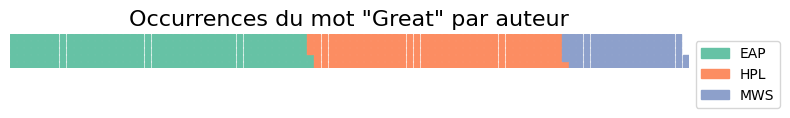

In [338]:
from pywaffle import Waffle
import matplotlib.pyplot as plt

plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=great_counts.to_dict(), 
    title={"label": 'Occurrences du mot "Great" par auteur', "fontsize": 16},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}, 
    figsize=(8, 5)
)

plt.show()


<div class="alert alert-block alert-warning">3. Refaire l’analyse avec le mot “impossible ”.
<div/>

In [339]:
data["cleaned_text"] = data["cleaned_text"].str.lower()

data["contains_impossible"] = data["cleaned_text"].str.contains(r'\bimpossible\b', regex=True)

impossible_counts = data.groupby("author")["contains_impossible"].sum()

print(impossible_counts)

author
EAP    53
HPL    13
MWS    13
Name: contains_impossible, dtype: int64


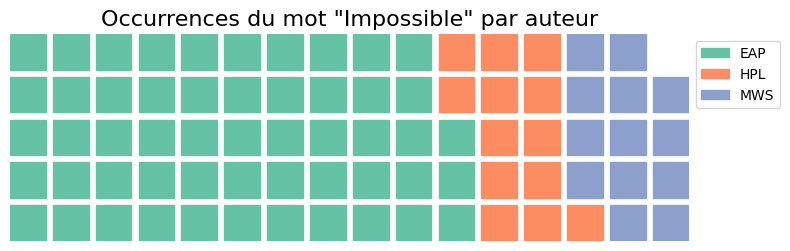

In [340]:
from pywaffle import Waffle
import matplotlib.pyplot as plt

plt.figure(
    FigureClass=Waffle, 
    rows=5,  
    values=impossible_counts.to_dict(), 
    title={"label": 'Occurrences du mot "Impossible" par auteur', "fontsize": 16},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    figsize=(8, 5)
)

plt.show()


<div class="alert alert-block alert-warning">4. En utilisant la fonction wordCloud, faire trois nuages de mots pour représenter les mots les plus utilisés par chaque auteur.
<div/>

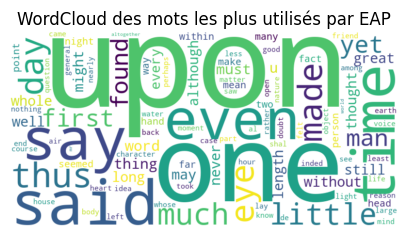

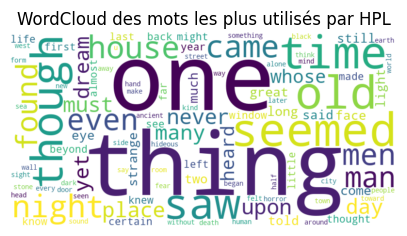

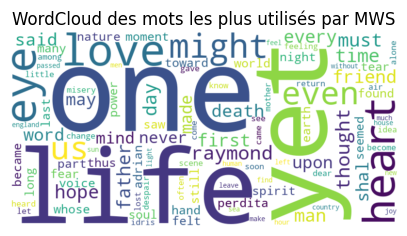

In [329]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

authors = data["author"].unique()

for author in authors:
    text = " ".join(data[data["author"] == author]["cleaned_text"])

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud des mots les plus utilisés par {author}")
    plt.show()

<div class="alert alert-block alert-warning">5. En utilisant la fonction wordCloud, montrer les 100 meilleurs mots positifs et négatifs utilisés par les auteurs.
<div/>

[nltk_data] Downloading package opinion_lexicon to C:\Users\pc
[nltk_data]     cam\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


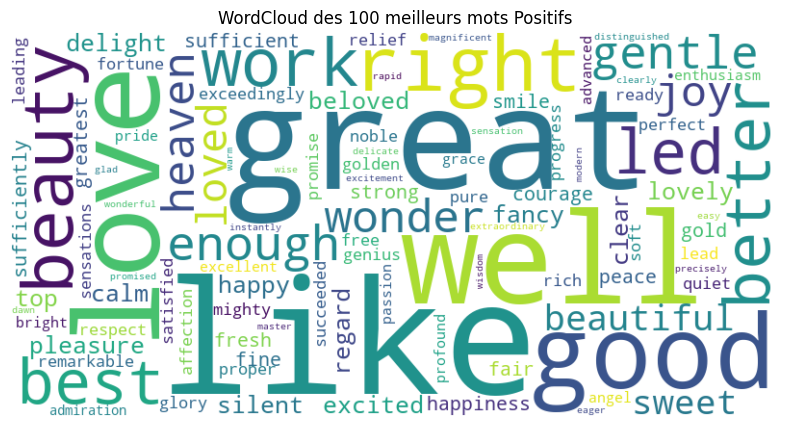

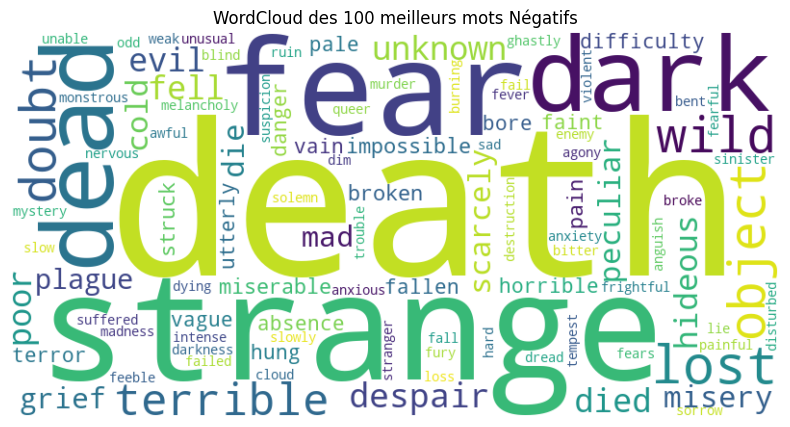

In [327]:
from nltk.corpus import opinion_lexicon
import nltk
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('opinion_lexicon')

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

def extract_sentiment_words(text, sentiment_set):
    words = text.split()
    return [word for word in words if word in sentiment_set]

data["positive_words"] = data["cleaned_text"].apply(lambda x: extract_sentiment_words(x, positive_words))
data["negative_words"] = data["cleaned_text"].apply(lambda x: extract_sentiment_words(x, negative_words))

all_positive_words = [word for sublist in data["positive_words"] for word in sublist]
all_negative_words = [word for sublist in data["negative_words"] for word in sublist]

top_100_positive = dict(Counter(all_positive_words).most_common(100))
top_100_negative = dict(Counter(all_negative_words).most_common(100))

for sentiment, word_freq in [("Positifs", top_100_positive), ("Négatifs", top_100_negative)]:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud des 100 meilleurs mots {sentiment}")
    plt.show()

<div class="alert alert-block alert-warning">6. Identifier la polarité la plus fréquente pour chaque auteur (analyse de sentiment).
<div/>

author
EAP    0.054006
HPL    0.010644
MWS    0.049186
Name: polarity, dtype: float64


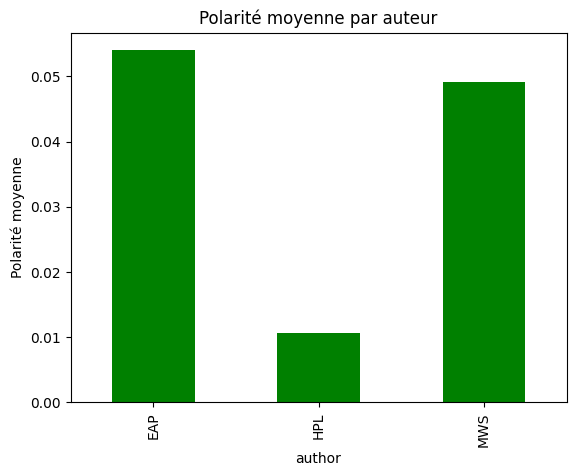

In [ ]:
from textblob import TextBlob

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

data["polarity"] = data["cleaned_text"].apply(get_polarity)

polarity_per_author = data.groupby("author")["polarity"].mean()

print(polarity_per_author)

polarity_per_author.plot(kind='bar', title="Polarité moyenne par auteur", color=["green" if x > 0 else "red" for x in polarity_per_author])
plt.ylabel("Polarité moyenne")
plt.show()


In [126]:
data.to_csv("spooky_cleaned.csv", index=False)

<div class="alert alert-block alert-warning">7. Analyser les données et déterminer les méthodes de prétraitement les plus adéquates pour ce dataset, en justifiant le choix des techniques.
<div/>

In [ ]:
import re

def detect_repeated_words(text):
    """Détecte les mots répétés consécutivement dans un texte."""
    repeated_words = re.findall(r'\b(\w+)(\s+\1\b)+', text, flags=re.IGNORECASE)
    return repeated_words if repeated_words else None

data["repeated_words"] = data["text"].apply(detect_repeated_words)
texts_with_repetitions = data[data["repeated_words"].notna()]

print(f"Nombre de textes avec répétition de mots : {len(texts_with_repetitions)}")
print(texts_with_repetitions[["text", "repeated_words"]].head(10))


Nombre de textes avec répétition de mots : 164
                                                   text  \
103   He began to answer with violence: "Yes, yes, I...   
180   At Lawrence he had been prominent in the mock ...   
197   "Ha ha ha" said that gentleman "he he he hi hi...   
225   A closer scrutiny, however, satisfied me that ...   
299   Who or what then, was my great great grandmother?   
496   "What can I do?" she cried, "I am lost we are ...   
859                         He shrieked once once only.   
1167  The usual expression of his eyes was soft, tho...   
1189  Yes it was despair I felt; for the first time ...   
1366  I I alone was the cause of his defeat and just...   

                                         repeated_words  
103                                       [(you,  You)]  
180                                   [(Tappa,  Tappa)]  
197   [(Ha,  ha), (he,  he), (hi,  hi), (ho,  ho), (...  
225                                         [(Ha,  ha)]  
299          

In [103]:
def detect_repeated_chars(text):
    repeated_chars = re.findall(r'(\w)\1{2,}', text)
    return repeated_chars if repeated_chars else None

data["repeated_chars"] = data["text"].apply(detect_repeated_chars)
texts_with_char_repetitions = data[data["repeated_chars"].notna()]

print(f"Nombre de textes avec répétition de caractères : {len(texts_with_char_repetitions)}")
print(texts_with_char_repetitions[["text", "repeated_chars"]].head(10))

Nombre de textes avec répétition de caractères : 6
                                                    text repeated_chars
3925             "Eh ya ya ya yahaah e'yayayayaaaa . . .            [a]
4119   I hardly know, but in a few moments I sank lif...            [I]
9292   She flapped her wings with prodigious effect s...            [o]
13874  I shudder tonight as I think of it; shudder ev...            [I]
14012                         EH AHHHH AH E'YAAHHHH. . .         [H, H]
16920  All she did, however, was to stand up in a cor...            [o]


In [106]:
pd.set_option("display.max_colwidth", None) 
print(texts_with_char_repetitions[["text", "repeated_chars"]].head(10))

                                                                                                                                                                                                                                                                                   text  \
3925                                                                                                                                                                                                                                            "Eh ya ya ya yahaah e'yayayayaaaa . . .   
4119   I hardly know, but in a few moments I sank lifeless to the ground; and so would that then all had been at an end CHAPTER VIII I was carried to the next town: fever succeeded to convulsions and faintings, for some weeks my unhappy spirit hovered on the very verge of death.   
9292             She flapped her wings with prodigious effect so so and, as for her crow, it was delicious Cock a doodle doo cock a doodle doo cock a d

In [109]:
import json

with open("homoglyph_map.json", "r", encoding="utf-8") as f:
    homoglyph_map = json.load(f)
    
def detect_homoglyphs(text):
    detected = [char for char in text if any(char in homoglyphs for homoglyphs in homoglyph_map.values())]
    return detected if detected else None

data["homoglyphs_detected"] = data["text"].apply(detect_homoglyphs)

texts_with_homoglyphs = data[data["homoglyphs_detected"].notna()]


In [111]:
import pandas as pd
print(texts_with_homoglyphs[["text", "homoglyphs_detected"]])


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text  \
101                                                                                                                                                                                                                                                                                     "But, my dear fellow, you are joking then," said I, "this is a very passable skull indeed, I may say that it is a very excellent skull, according to th

In [119]:
import re

def detect_urls_emails_html(text):
    urls = re.findall(r'http[s]?://\S+', text)  
    emails = re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text)
    html_tags = re.findall(r'<[^>]+>', text)  

    if urls or emails or html_tags:
        return {"urls": urls, "emails": emails, "html_tags": html_tags}
    return None 

data["detected_noise"] = data["text"].apply(detect_urls_emails_html)

texts_with_noise = data[data["detected_noise"].notna()]
print(texts_with_noise[["text", "detected_noise"]])


Empty DataFrame
Columns: [text, detected_noise]
Index: []


In [124]:
import re

def detect_special_chars(text):
    """Detects special characters excluding punctuation in a text."""
    special_chars = re.findall(r'[^a-zA-Z0-9\s.,!?;:\'\"]', text)  # Allow letters, numbers, spaces, and punctuation
    return special_chars if special_chars else None

# Apply to the entire dataset
data["special_chars_detected"] = data["cleaned_text"].apply(detect_special_chars)

# Extract texts that contain special characters
texts_with_special_chars = data[data["special_chars_detected"].notna()]


In [125]:
print(texts_with_special_chars[["text", "special_chars_detected"]])

Empty DataFrame
Columns: [text, special_chars_detected]
Index: []
